## Models

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score

import os
import sys
module_path = os.path.abspath(os.pardir)
if module_path not in sys.path:
    sys.path.append(module_path)
    
from utils import evaluate

sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

In [2]:
# load the jsonl files
train_df = pd.read_json('../data/raw/train.jsonl', lines=True, )
dev_seen_df = pd.read_json('../data/raw/dev_seen.jsonl', lines=True)
dev_unseen_df = pd.read_json('../data/raw/dev_unseen.jsonl', lines=True)
test_seen_df = pd.read_json('../data/raw/test_seen.jsonl', lines=True)
test_unseen_df = pd.read_json('../data/raw/test_unseen.jsonl', lines=True)

### Split

In [3]:
# create train set
train_df = train_df.set_index('id')

# test set
test_df = pd.concat([dev_seen_df, dev_unseen_df, test_seen_df])
test_df = test_df.drop_duplicates(subset='id')
test_df = test_df.set_index('id')

# holdout set
hold_df = test_unseen_df.set_index('id')

In [4]:
# confirm number of memes
ids = list(train_df.index)+list(test_df.index)+list(hold_df.index)
assert(len(ids) == len(set(ids)))

# display train, test, holdout sizes
print(f"There are {len(ids):,} memes.")
print(f"Train size:\t{len(train_df) / len(ids):.2%}")
print(f"Test size:\t{len(test_df) / len(ids):.2%}")
print(f"Holdout size:\t{len(hold_df) / len(ids):.2%}")

There are 12,140 memes.
Train size:	70.02%
Test size:	13.51%
Holdout size:	16.47%


In [5]:
# create X, y
X_train, X_test, X_hold = train_df['text'], test_df['text'], hold_df['text']
y_train, y_test, y_hold = train_df['label'], test_df['label'], hold_df['label']

## Text Preprocessing
### Vectorize

In [6]:
# instantiate vectorizer
vectorizer = CountVectorizer()

# fit and transform on train
X_train_vec = vectorizer.fit_transform(X_train)

# transform val
X_test_vec = vectorizer.transform(X_test)

## Dummy Baseline

In [7]:
# training data base rate
y_train.value_counts(normalize=True)

0    0.644824
1    0.355176
Name: label, dtype: float64

In [8]:
# baseline prediction of predicting hateful meme at the base rate found in the train set
dummy = DummyClassifier(strategy='stratified', random_state=42)

# fit on train 
dummy.fit(X_train_vec, y_train)

DummyClassifier(random_state=42, strategy='stratified')

Training Metrics
Accuracy: 0.539
Precision: 0.347
Recall: 0.339
f1: 0.343
----------
Testing Metrics
Accuracy: 0.526
Precision: 0.466
Recall: 0.368
f1: 0.411


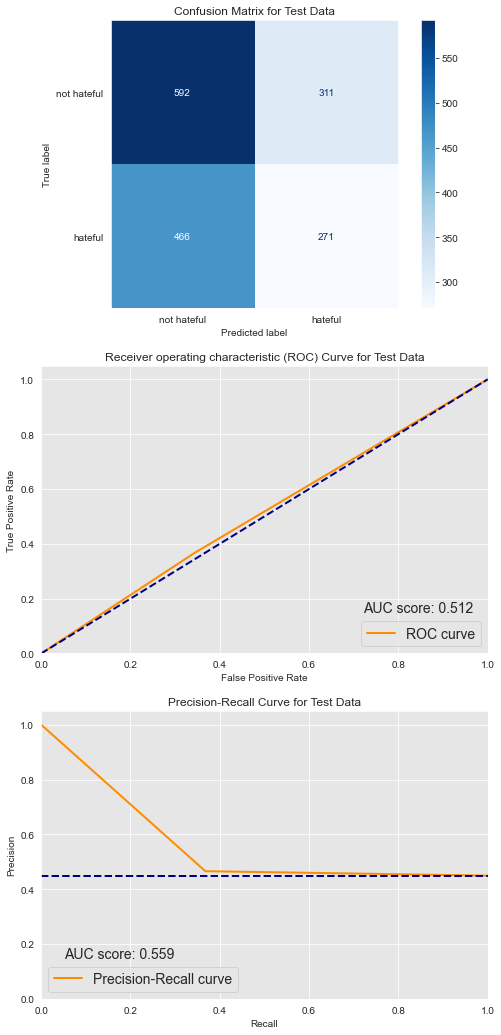

In [9]:
# evaluate model on train and test
evaluate(dummy, X_train_vec, y_train, X_test_vec, y_test)

## First Simple Model - Bag of Words

### Naive Bayes Classifier

In [12]:
# instantiate classifier
clf = MultinomialNB()

# fit on train 
clf.fit(X_train_vec, y_train)

MultinomialNB()

Training Metrics
Accuracy: 0.824
Precision: 0.790
Recall: 0.685
f1: 0.734
----------
Testing Metrics
Accuracy: 0.591
Precision: 0.575
Recall: 0.343
f1: 0.430


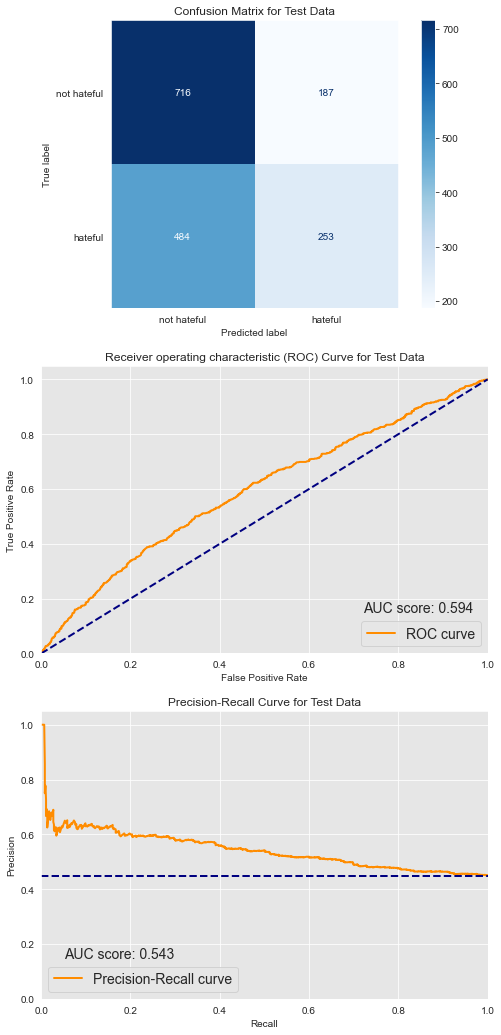

In [13]:
# evaluate model on train and test
evaluate(clf, X_train_vec, y_train, X_test_vec, y_test)